In [1]:
from create_datasets import read_json_dataset
from dict_utils import unfold_to_list, fold_from_list
from pipeline import Pipeline, FewShotPipeline, FineTuningFewShotPipeline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


def add_lerc_preds(data, lerc_preds_dir, split):
    lerc_preds = read_json_dataset(lerc_preds_dir, split)
        
    for dataset, d in lerc_preds.items():
        for example_id, score in d.items():
            data[dataset][example_id]["LERC"] = (score["pred_score"] - 1) / (5-1)
    return data

In [2]:
DATASET_DIR = "../data/lr_experiments"
LERC_PREDS_DIR = f"{DATASET_DIR}/lerc_preds"

RESULTS_DIR = "./experiments_20220621/results/all-data"
IMAGES_DIR = "./experiments_20220621/images/all-data"

# Read datasets
train = read_json_dataset(DATASET_DIR, "train_metrics")
dev = read_json_dataset(DATASET_DIR, "dev_metrics")
test = read_json_dataset(DATASET_DIR, "test_metrics")
print(len(train), len(dev), len(test))

# Add ALL-DATA LERC predictions
print(LERC_PREDS_DIR)
add_lerc_preds(train, LERC_PREDS_DIR, "train")
add_lerc_preds(dev, LERC_PREDS_DIR, "dev")
add_lerc_preds(test, LERC_PREDS_DIR, "test")

# Create dataframe from dict
train_df = pd.DataFrame(unfold_to_list(train, "dataset", "example_id"))
dev_df   = pd.DataFrame(unfold_to_list(dev, "dataset", "example_id"))
test_df  = pd.DataFrame(unfold_to_list(test, "dataset", "example_id"))
print(train_df.shape, dev_df.shape, test_df.shape)

# Apply min-max scaling
train_df["score_scaled"] = train_df.score.apply(lambda s: (s-1)/(5-1))
dev_df["score_scaled"] = dev_df.score.apply(lambda s: (s-1)/(5-1))
test_df["score_scaled"] = test_df.score.apply(lambda s: (s-1)/(5-1))

6 6 6
../data/lr_experiments/lerc_preds
(31069, 49) (4009, 49) (6321, 49)


In [3]:
DATASETS = list(train.keys())

METRICS = [
    # Bleu
    'bleu1', 'bleu2', 'bleu3', 'bleu4', 
    # 'hf_bleu1', 'hf_bleu2', 'hf_bleu3', 'hf_bleu4', 
    'rougeL', 
    # 'hf_rougeL', 'hf_rougeLsum',
    'hf_rouge1', 'hf_rouge2',
    'meteor',
    'recall', 'precision', 'f1_score',
    'sari_context', 'sari_question',
    # Token overlap when 1st error occurred
    'precision_at_err1', 'recall_at_err1',
    # Confusion matrix
    'tp', 'fn', 'fp',
    # Edit scores ------
    'char_edit_score',
    'word_edit_score',
    # Learned metrics -------
    'bertscore', 
    'bleurt',
    # Input statistics ------
    'candidatelength_word',
    'candidatelength_char',
    'candidatenunique_words',
    'referencelength_word',
    'referencelength_char',
    'referencenunique_words',
    'contextlength_word',
    'contextlength_char',
    'contextnunique_words',
    'questionlength_word',
    'questionlength_char',
    'questionnunique_words',
]

TARGET = "score_scaled"

**Validate numbers reported in original MOCHA paper**

Most of the values are close to the numbers reported in the paper. The ones that are not, are consistently higher.

In [4]:
from scipy.stats import pearsonr

for dataset in DATASETS:
    print(); print("---- DEV SET ----")
    _df = dev_df[dev_df.dataset == dataset]
    print(dataset, "bleu1", round(pearsonr(_df["score_scaled"], _df["bleu1"])[0], 3))
    print(dataset, "meteor", round(pearsonr(_df["score_scaled"], _df["meteor"])[0], 3))
    print(dataset, "rougeL", round(pearsonr(_df["score_scaled"], _df["rougeL"])[0], 3))
    print(dataset, "bert-score", round(pearsonr(_df["score_scaled"], _df["bertscore"])[0], 3))
    print()
    
    print("TEST SET")
    _df = test_df[test_df.dataset == dataset]
    print(dataset, "bleu1", round(pearsonr(_df["score_scaled"], _df["bleu1"])[0], 3))
    print(dataset, "meteor", round(pearsonr(_df["score_scaled"], _df["meteor"])[0], 3))
    print(dataset, "rougeL", round(pearsonr(_df["score_scaled"], _df["rougeL"])[0], 3))
    print(dataset, "bert-score", round(pearsonr(_df["score_scaled"], _df["bertscore"])[0], 3))
    print()


---- DEV SET ----
cosmosqa bleu1 0.66
cosmosqa meteor 0.697
cosmosqa rougeL 0.702
cosmosqa bert-score 0.805

TEST SET
cosmosqa bleu1 0.671
cosmosqa meteor 0.712
cosmosqa rougeL 0.701
cosmosqa bert-score 0.78


---- DEV SET ----
drop bleu1 0.409
drop meteor 0.664
drop rougeL 0.48
drop bert-score 0.174

TEST SET
drop bleu1 0.388
drop meteor 0.568
drop rougeL 0.366
drop bert-score 0.329


---- DEV SET ----
mcscript bleu1 0.182
mcscript meteor 0.461
mcscript rougeL 0.225
mcscript bert-score 0.173

TEST SET
mcscript bleu1 0.261
mcscript meteor 0.503
mcscript rougeL 0.297
mcscript bert-score 0.195


---- DEV SET ----
narrativeqa bleu1 0.403
narrativeqa meteor 0.606
narrativeqa rougeL 0.434
narrativeqa bert-score 0.419

TEST SET
narrativeqa bleu1 0.472
narrativeqa meteor 0.616
narrativeqa rougeL 0.496
narrativeqa bert-score 0.535


---- DEV SET ----
quoref bleu1 0.675
quoref meteor 0.729
quoref rougeL 0.713
quoref bert-score 0.208

TEST SET
quoref bleu1 0.578
quoref meteor 0.716
quoref rouge

# Regression Experiments

In [5]:
def get_subset(df, dataset = None, col="dataset"):
    return df[df[col] == dataset].copy() if dataset else df
    
def get_all_datasets(df, datasets, include_all=True):
    result = {} if not include_all else {"all": df.copy()}
    
    for dataset in datasets:
        result.update({dataset: get_subset(df, dataset)})
        
    return result

def get_loov_datasets(df, datasets):
    result = {}

    for dataset in datasets:
        loo_datasets = [get_subset(df, d) for d in datasets if d != dataset]
        loo_dataset = pd.concat(loo_datasets)
        
        result.update({f"except_{dataset}": loo_dataset})
        
    return result


# Create dict w/ data
TRAIN_DATASETS = get_all_datasets(train_df, DATASETS)
DEV_DATASETS   = get_all_datasets(dev_df, DATASETS)
TEST_DATASETS  = get_all_datasets(test_df, DATASETS)

TRAIN_LOO_WRONG_LERC_DATASETS = get_loov_datasets(train_df, DATASETS)

In [6]:
from io_utils import create_db_engine, from_yaml
    
db_configs = from_yaml("db_configs.yaml", "./configs")
engine = create_db_engine(db_configs)



def to_csv(data: pd.DataFrame, name: str, parent_dir: str):
    
    
    
def to_sql(data: pd.DataFrame, name: str, parent_dir: str):
    """
    
    Parameters
    ----------
    data: pandas.DataFrame
        The rows to dump to the sql connection.
        
    name: str
        The table name to upload the examples to.
        
    parent_dir: str
        The 
    """

In [7]:
df = pd.DataFrame({"a": [1, 2, 3], "b": ["a", "b", "a"]})
df.to_sql("individual_metrics", schema="ensemble_metrics_20220621", if_exists="append", con=engine)

3

###### Add QASPER

In [8]:
# Add QASPER
qasper = read_json_dataset(DATASET_DIR, "qasper_metrics")
print("Qasper:", len(qasper))

qasper_df = pd.DataFrame(unfold_to_list(qasper, "dataset", "example_id"))
print("Qasper:", qasper_df.shape)

DEV_DATASETS.update({f"qasper": qasper_df.copy()})

# Let us measure the values per annotation type
for annot_type in sorted(qasper_df.annotation_type.unique()):
    DEV_DATASETS.update({f"qasper_{annot_type}": qasper_df[qasper_df.annotation_type == annot_type].copy()})

Qasper: 1
Qasper: (200, 51)


# Baselines (ALL DATA)

In [9]:
def fit(
        model_class,
        model_hparams,
        features,
        target,
        train_datasets,
        split_frac=None,
        with_std=True,
        with_pca=False,
        seed=817237,
        pipeline_class=Pipeline,
    ) -> dict:
    pipelines = {}
    
    for train_name, train_data in train_datasets.items():
        pipeline = pipeline_class(model_class, model_hparams, train_name, features, target, seed=seed)
        pipeline.load_data(train_data)
        if split_frac and isinstance(split_frac, float):
            pipeline.split(holdout_fraction=split_frac)

        pipeline.preprocess(with_std=with_std, with_pca=with_pca)
        pipeline.fit()
        pipelines[train_name] = pipeline

    return pipelines


def evaluate(pipelines, eval_datasets):
    results = []
    for train_name, pipeline in pipelines.items():
        result = pipeline.evaluate_multiple(eval_datasets)
        results.extend(result)
    return results

def evaluate_loo(pipelines, eval_datasets):
    results = []
    for train_name, pipeline in pipelines.items():
        loo_dataset = train_name.rpartition("_")[-1]
        result = pipeline.evaluate_multiple({loo_dataset: eval_datasets[loo_dataset]})
        results.extend(result)

    return results

## Individual metrics

In [10]:
class IndividualMetric:
    def __init__(self, feature=None):
        self.feature = feature
                
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        if self.feature is None:
            raise RuntimeError("No feature specified")

        y_pred = X[self.feature]
        
        assert len(y_pred) == X.shape[0]
        return y_pred

In [11]:
individual_results = []
for metric in ["LERC"] + METRICS: 
    ps = fit(IndividualMetric, {"feature": metric}, [metric], TARGET, {"all": TRAIN_DATASETS["all"]}, with_pca=False, with_std=False)
    results = evaluate(ps, DEV_DATASETS)
    for r in results:
        r["model_classpath"] = metric
    
    individual_results.extend(results)

individual_results = pd.DataFrame(individual_results)
individual_results.to_csv(f"{RESULTS_DIR}/individual_metrics.csv")
individual_results.head()

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

mse        r2   pearson  spearman  kendalltau features        target  \
0  0.054807  0.609562  0.810055  0.784910    0.614783   [LERC]  score_scaled   
1  0.052269  0.652098  0.859841  0.820316    0.661619   [LERC]  score_scaled   
2  0.049659  0.630796  0.816460  0.739219    0.591648   [LERC]  score_scaled   
3  0.054287  0.629135  0.812387  0.786814    0.619824   [LERC]  score_scaled   
4  0.059730  0.601472  0.793851  0.786998    0.609705   [LERC]  score_scaled   

  model_classpath        model_hparams trained_on evaluated_on  
0            LERC  {'feature': 'LERC'}        all          all  
1            LERC  {'feature': 'LERC'}        all     cosmosqa  
2            LERC  {'feature': 'LERC'}        all         drop  
3            LERC  {'feature': 'LERC'}        all     mcscript  
4            LERC  {'feature': 'LERC'}        all  narrativeqa

In [12]:
individual_results.head(10)

mse         r2   pearson  spearman  kendalltau features        target  \
0  0.054807   0.609562  0.810055  0.784910    0.614783   [LERC]  score_scaled   
1  0.052269   0.652098  0.859841  0.820316    0.661619   [LERC]  score_scaled   
2  0.049659   0.630796  0.816460  0.739219    0.591648   [LERC]  score_scaled   
3  0.054287   0.629135  0.812387  0.786814    0.619824   [LERC]  score_scaled   
4  0.059730   0.601472  0.793851  0.786998    0.609705   [LERC]  score_scaled   
5  0.036726   0.509015  0.776692  0.769771    0.618201   [LERC]  score_scaled   
6  0.059309   0.556567  0.814635  0.782033    0.607824   [LERC]  score_scaled   
7  3.748460 -32.923191  0.694181  0.453242    0.366154   [LERC]  score_scaled   
8  2.682101 -38.866634  0.559612  0.307720    0.247651   [LERC]  score_scaled   
9  7.941154 -32.088142  0.710596  0.566947    0.478091   [LERC]  score_scaled   

  model_classpath        model_hparams trained_on        evaluated_on  
0            LERC  {'feature': 'LERC'}        all                 all  
1            LERC  {'feature': 'LERC'}        all            cosmosqa  
2            LERC  {'feature': 'LERC'}        all                drop  
3            LERC  {'feature': 'LERC'}        all            mcscript  
4            LERC  {'feature': 'LERC'}        all         narrativeqa  
5            LERC  {'feature': 'LERC'}        all              quoref  
6            LERC  {'feature': 'LERC'}        all           socialiqa  
7            LERC  {'feature': 'LERC'}        all              qasper  
8            LERC  {'feature': 'LERC'}        all  qasper_abstractive  
9            LERC  {'feature': 'LERC'}        all      qasper_boolean

## Average

In [13]:
class AverageBaseline:                
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        y_pred = np.mean(X, axis=1)
        assert len(y_pred) == X.shape[0]
        return y_pred

In [14]:
top3_features  = {
    "cosmosqa": ["bleurt", "bertscore", "meteor"],
    "drop": ["hf_rouge1", "meteor", "f1_score"],
    "mcscript": ["bleurt", "meteor", "hf_rouge1"],
    "narrativeqa": ["bleurt", "bertscore", "meteor"],
    "quoref": ["hf_rouge1", "meteor", "bleurt"],
    "socialiqa": ["bleurt", "meteor", "precision"],
}

ad_avg_results = []
# All datasets experiment
print("AVG Baseline")
ad_avg_pipelines = fit(AverageBaseline, {}, METRICS, TARGET, TRAIN_DATASETS)
ad_avg_results.extend(evaluate(ad_avg_pipelines, DEV_DATASETS))

ad_avg_pipelines = fit(AverageBaseline, {}, ["LERC"] + METRICS, TARGET, TRAIN_DATASETS)
ad_avg_results.extend(evaluate(ad_avg_pipelines, DEV_DATASETS))

feature_set = set()
for dataset in DATASETS:
    features = tuple(top3_features[dataset])

    if features not in feature_set:
        ad_avg_pipelines = fit(AverageBaseline, {}, list(features), TARGET, TRAIN_DATASETS)
        results = evaluate(ad_avg_pipelines, DEV_DATASETS)
        
        for r in results:
            r["model_classpath"] = str(features)
        ad_avg_results.extend(results)
        feature_set.add(features)

        ad_avg_pipelines = fit(AverageBaseline, {}, ["LERC"] + list(features), TARGET, TRAIN_DATASETS)
        results = evaluate(ad_avg_pipelines, DEV_DATASETS)
        
        for r in results:
            r["model_classpath"] = str(["LERC"]+ list(features))
        ad_avg_results.extend(results)
        feature_set.add(tuple(["LERC"]+ list(features)))
    
ad_avg_results = pd.DataFrame(ad_avg_results).reset_index(drop=True)
ad_avg_results.to_csv(f"{RESULTS_DIR}/avg.csv")

AVG Baseline


## Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# All datasets experiment
lr_results = []

lr_pipelines = fit(LinearRegression, {}, METRICS, TARGET, TRAIN_DATASETS)
lr_results.extend(evaluate(lr_pipelines, DEV_DATASETS))

lr_pipelines = fit(LinearRegression, {}, METRICS + ["LERC"], TARGET, TRAIN_DATASETS)
lr_results.extend(evaluate(lr_pipelines, DEV_DATASETS))

lr_results = pd.DataFrame(lr_results)
lr_results.to_csv(f"{RESULTS_DIR}/linear_regression.csv")

## L1 Regression (Lasso Regression)

In [17]:
from sklearn.linear_model import Lasso

from sklearn.model_selection import ParameterSampler
from scipy.stats import expon


def get_alpha(args):
    return eval(args)["alpha"]


def plot_metric_by_alpha(data, metric, **kwargs):
    n_plots = data.trained_on.nunique()
    n_cols = 3

    n_rows = n_plots // n_cols
    n_rows += n_plots % n_cols

    position = range(1, n_plots+1)

    fig = plt.figure(1, figsize=(10, 10), dpi=150)

    for k, trained_on in enumerate(data.trained_on.unique()):
        d = data[(data["trained_on"] == trained_on)]
        d = d.sort_values(by="alpha")
        ax = fig.add_subplot(n_rows, n_cols, position[k])
        sns.lineplot(data=d, x="alpha", y=metric, ax=ax, **kwargs)
        ax.set_title(f"Trained_on={trained_on}")

    plt.tight_layout()
    
    
def get_feat_information(pipelines, results, experiment_type, metrics):
    results = results.copy()
    # For every set of experiments
    for i, experiments in pipelines.items():
        # Get the experiment_type pipeline (AD or LOO)
        for trained_on, pipeline in experiments[experiment_type].items():
            # Determine the important features and their importance
            _feat_importance = pipeline.model.coef_
            _mask = np.abs(_feat_importance) > 1e-6
            
            trained_on_mask = results["trained_on"] == trained_on
            i_mask = results["i"] == i

            _feats = np.argsort(np.abs(_feat_importance))[::-1]
            _featnames = tuple(metrics[ix] for ix in _feats if _mask[ix])
            _feats = {metrics[ix]: _feat_importance[ix] for ix in _feats if _mask[ix]}
            _feats["intercept_"] = pipeline.model.intercept_

            results.loc[trained_on_mask & i_mask, "n_features"] =  sum(_mask)
            results.loc[trained_on_mask & i_mask, "feat_names"] = str(_featnames)
            results.loc[trained_on_mask & i_mask, "feat_importance"] = str(_feats)

    return results


def group_by(results):
    
    # TODO
    # - Add std to tables
    results = results.copy()
    results["model_hparams"] = results["model_hparams"].apply(eval)
    results["model_seed"] = results["model_hparams"].apply(lambda d: d.pop("random_state"))
    results["model_hparams"] = results["model_hparams"].apply(str)
    return results\
        .groupby(['model_classpath', 'model_hparams', 'features', 'target', 'trained_on', 'evaluated_on'])\
        .mean()\
        .reset_index()

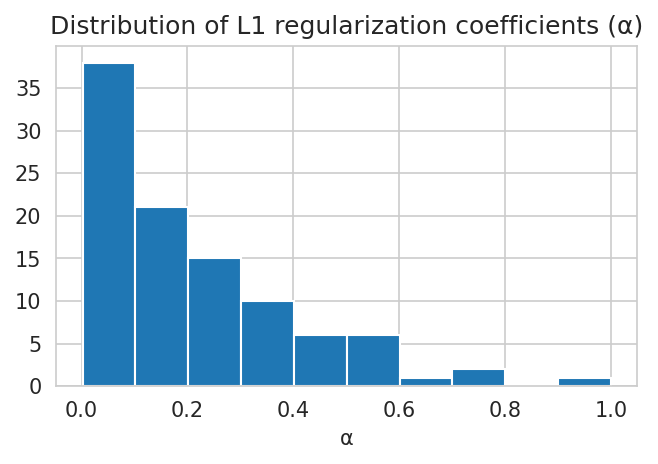

In [18]:
# We will perform model selection using L1 regression
# since it is known to enforce sparsity of the solution!
N_L1_MODELS = 100

L1_GRID = {'alpha': expon(loc=0, scale=0.20)}
L1_PARAMS = list(ParameterSampler(L1_GRID, n_iter=N_L1_MODELS, random_state=81723))

plt.figure(figsize=(5, 3), dpi=150)
plt.hist([p["alpha"] for p in L1_PARAMS])
plt.title("Distribution of L1 regularization coefficients (α)")
plt.xlabel("α")
plt.savefig(f"{IMAGES_DIR}/l1_alphas_dist.png", dpi=150)
plt.show()

In [19]:
l1_pipelines = {}
ad_results = []
loo_results = []
for i, l1_hparams in enumerate(L1_PARAMS):
    if l1_hparams["alpha"] > 2:
        continue

    # All datasets experiment
    ad_l1_pipelines = fit(Lasso, l1_hparams, METRICS, TARGET, TRAIN_DATASETS)
    ad_l1_results = evaluate(ad_l1_pipelines, DEV_DATASETS)
    ad_l1_results = pd.DataFrame(ad_l1_results)
    ad_l1_results["i"] = i
    ad_results.append(ad_l1_results)

    # All (baseline) LR results
    l1_pipelines[i] = {"AD": ad_l1_pipelines}
    
l1_ad_results = pd.concat(ad_results).reset_index(drop=True)
l1_ad_results["alpha"] = l1_ad_results["model_hparams"].apply(get_alpha)

l1_ad_results = get_feat_information(l1_pipelines, l1_ad_results, "AD", METRICS)
l1_ad_results.to_csv(f"{RESULTS_DIR}/lasso_regression.csv")

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

In [20]:
plot_metric_by_alpha(l1_ad_results, "mse")
plt.savefig(f"{IMAGES_DIR}/l1_alldata_avg_mse_by_alpha.png", dpi=200)
plt.show()

plot_metric_by_alpha(l1_ad_results, "mse", hue="evaluated_on")
plt.savefig(f"{IMAGES_DIR}/l1_alldata_mse_by_alpha_discriminated_by_evaluation_set.png", dpi=200)
plt.show()

In [21]:
l1_pipelines = {}
ad_results = []
for i, l1_hparams in enumerate(L1_PARAMS):
    if l1_hparams["alpha"] > 2:
        continue

    # All datasets experiment
    ad_l1_pipelines = fit(Lasso, l1_hparams, METRICS + ["LERC"], TARGET, TRAIN_DATASETS)
    ad_l1_results = evaluate(ad_l1_pipelines, DEV_DATASETS)
    ad_l1_results = pd.DataFrame(ad_l1_results)
    ad_l1_results["i"] = i
    ad_results.append(ad_l1_results)

    # All (baseline) LR results
    l1_pipelines[i] = {"AD": ad_l1_pipelines}
    
l1_ad_results = pd.concat(ad_results).reset_index(drop=True)
l1_ad_results["alpha"] = l1_ad_results["model_hparams"].apply(get_alpha)

l1_ad_results = get_feat_information(l1_pipelines, l1_ad_results, "AD", METRICS + ["LERC"])
l1_ad_results.to_csv(f"{RESULTS_DIR}/lasso_regression_with_lerc.csv")

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


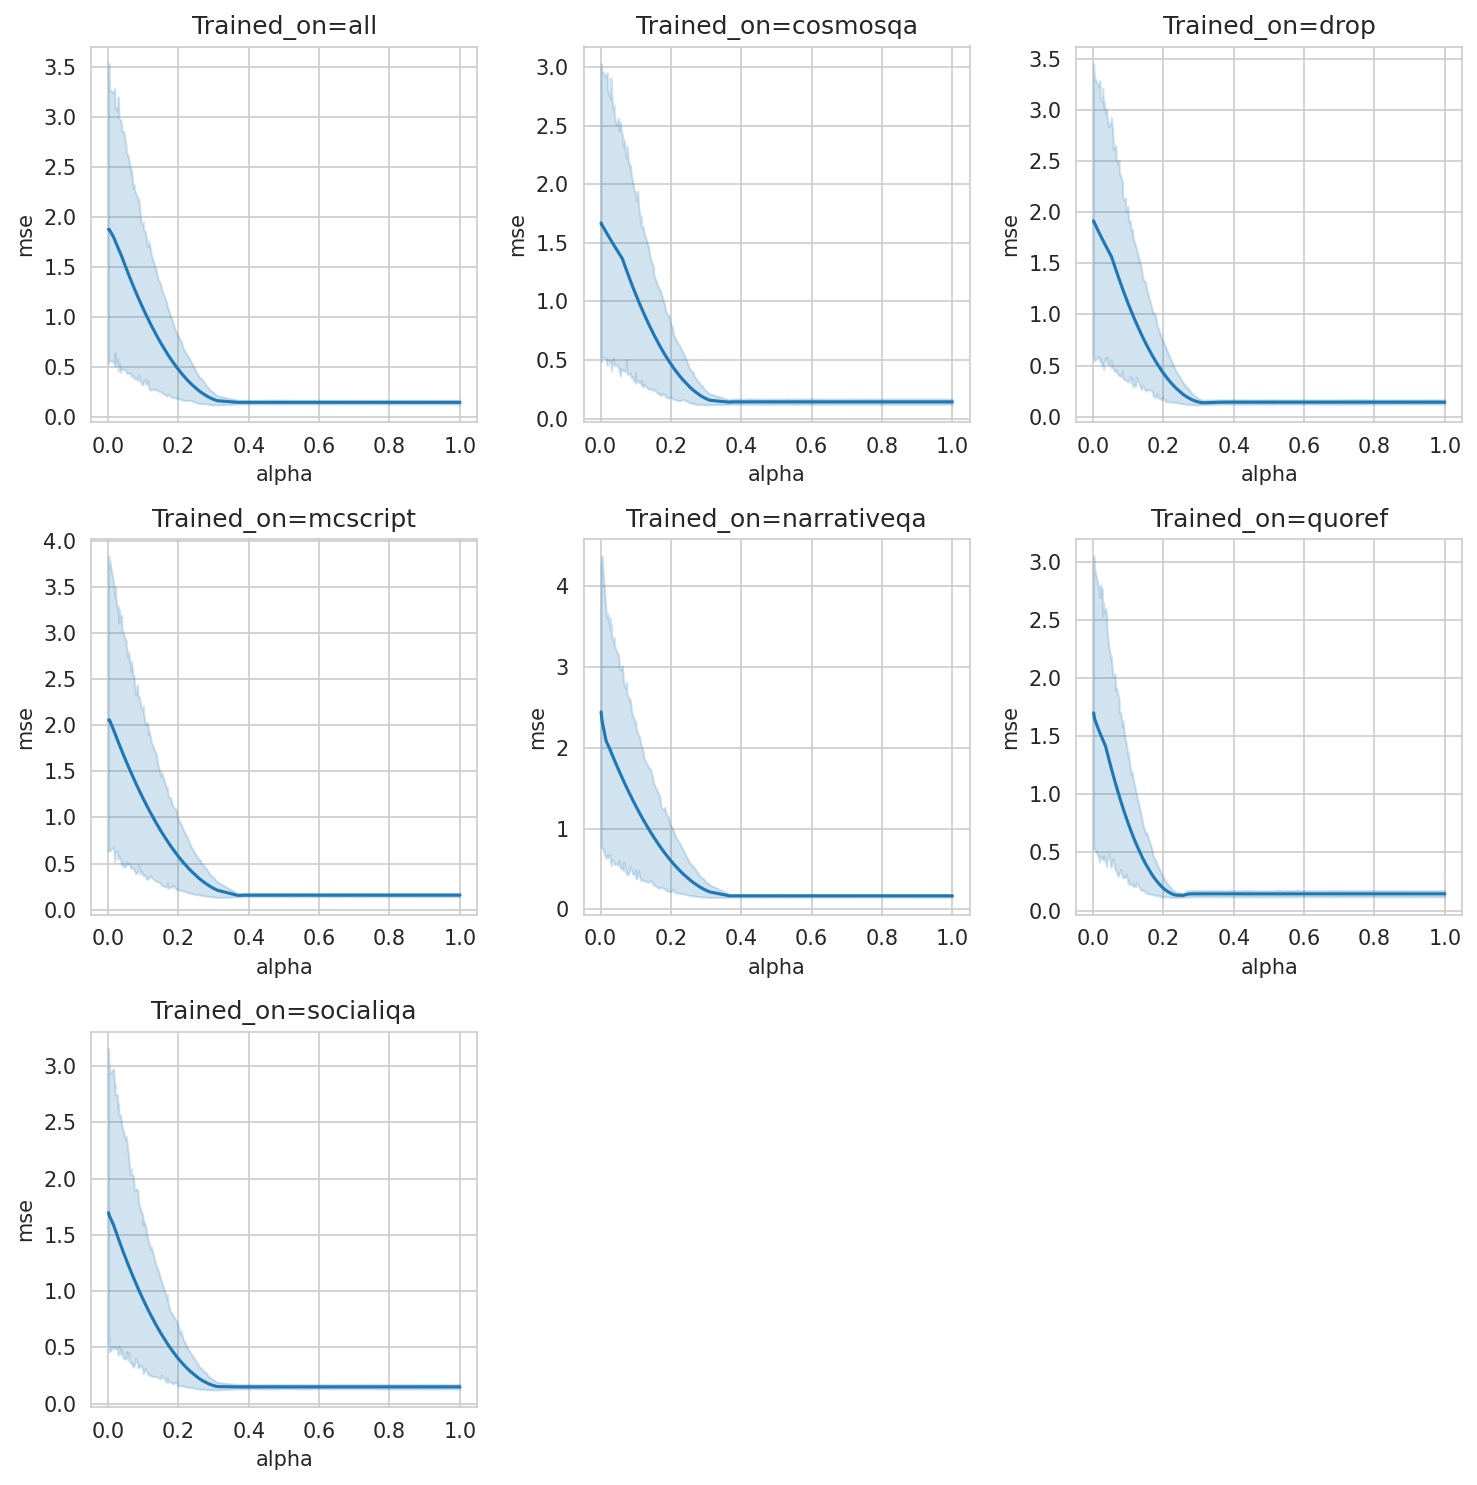

In [22]:
plot_metric_by_alpha(l1_ad_results, "mse")
plt.savefig(f"{IMAGES_DIR}/l1_alldata_w_lerc_avg_mse_by_alpha.png", dpi=200)
plt.show()

plot_metric_by_alpha(l1_ad_results, "mse", hue="evaluated_on")
plt.savefig(f"{IMAGES_DIR}/l1_alldata_w_lerc_mse_by_alpha_discriminated_by_evaluation_set.png", dpi=200)
plt.show()

## Random Forests

In [23]:
from sklearn.ensemble import RandomForestRegressor

rnd = np.random.default_rng(13)

ad_rf_def_results = []
for i in range(3):
    seed = rnd.integers(10**6)
    
    # All datasets experiment
    ad_rf_def_pipelines = fit(RandomForestRegressor, {"random_state": seed}, METRICS, TARGET, TRAIN_DATASETS)
    ad_rf_def_results.extend(evaluate(ad_rf_def_pipelines, DEV_DATASETS))
    
ad_rf_def_results = pd.DataFrame(ad_rf_def_results)
ad_rf_def_results["features"] = ad_rf_def_results["features"].astype(str)
ad_rf_def_results_gb = group_by(ad_rf_def_results)
ad_rf_def_results_gb.to_csv(f"{RESULTS_DIR}/random_forest.csv")

### With LERC

In [24]:
# All datasets experiment

rnd = np.random.default_rng(13)

ad_rf_def_results = []
for i in range(3):
    seed = rnd.integers(10**6)
    
    # All datasets experiment
    ad_rf_def_pipelines = fit(RandomForestRegressor, {"random_state": seed}, METRICS + ["LERC"], TARGET, TRAIN_DATASETS)
    ad_rf_def_results.extend(evaluate(ad_rf_def_pipelines, DEV_DATASETS))
    
ad_rf_def_results = pd.DataFrame(ad_rf_def_results)
ad_rf_def_results["features"] = ad_rf_def_results["features"].astype(str)
ad_rf_def_results_gb = group_by(ad_rf_def_results)
ad_rf_def_results_gb.to_csv(f"{RESULTS_DIR}/random_forest_with_lerc.csv")

## LightGBM

In [25]:
import lightgbm as lgb

rnd = np.random.default_rng(13)

lgbm_results = []
for i in range(10):
    seed = rnd.integers(10**6)
    lgbm_def_pipelines = fit(lgb.LGBMRegressor, {"random_state": seed}, METRICS, TARGET, TRAIN_DATASETS)
    lgbm_results.extend(evaluate(lgbm_def_pipelines, DEV_DATASETS))

lgbm_results = pd.DataFrame(lgbm_results)
lgbm_results["features"] = lgbm_results["features"].astype(str)
lgbm_results_gb = group_by(lgbm_results)
lgbm_results_gb.to_csv(f"{RESULTS_DIR}/lgbm.csv")

### With LERC

In [26]:
import lightgbm as lgb


rnd = np.random.default_rng(13)

lgbm_results = []
for i in range(10):
    seed = rnd.integers(10**6)
    lgbm_def_pipelines = fit(lgb.LGBMRegressor, {"random_state": seed}, METRICS + ["LERC"], TARGET, TRAIN_DATASETS)
    lgbm_results.extend(evaluate(lgbm_def_pipelines, DEV_DATASETS))

lgbm_results = pd.DataFrame(lgbm_results)
lgbm_results["features"] = lgbm_results["features"].astype(str)
lgbm_results_gb = group_by(lgbm_results)
lgbm_results_gb.to_csv(f"{RESULTS_DIR}/lgbm_with_lerc.csv")

## MLP


In [27]:
from sklearn.neural_network import MLPRegressor

mlp_results = []
rnd = np.random.default_rng(13)

for i in range(10):
    seed = rnd.integers(10**6)

    mlp_pipelines = fit(MLPRegressor, {"random_state": seed, "early_stopping": True}, METRICS, TARGET, TRAIN_DATASETS)
    mlp_results.extend(evaluate(mlp_pipelines, DEV_DATASETS))

    mlp_pipelines = fit(MLPRegressor, {"hidden_layer_sizes": (128, 64, 32), "random_state": seed, "early_stopping": True}, METRICS, TARGET, TRAIN_DATASETS)
    mlp_results.extend(evaluate(mlp_pipelines, DEV_DATASETS))

mlp_results = pd.DataFrame(mlp_results)
mlp_results["features"] = mlp_results["features"].astype(str)
mlp_results_gb = group_by(mlp_results)
mlp_results_gb.to_csv(f"{RESULTS_DIR}/mlp.csv")

In [29]:
rnd = np.random.default_rng(13)

mlp_results = []
for i in range(10):
    seed = rnd.integers(10**6)

    # -------------------------------------------------------
    # WITH LERC 
    # -------------------------------------------------------
    mlp_pipelines = fit(MLPRegressor, {"random_state": seed, "early_stopping": True}, METRICS + ["LERC"], TARGET, TRAIN_DATASETS)
    mlp_results.extend(evaluate(mlp_pipelines, DEV_DATASETS))
    
    mlp_pipelines = fit(MLPRegressor, {"hidden_layer_sizes": (128, 64, 32), "random_state": seed, "early_stopping": True}, METRICS + ["LERC"], TARGET, TRAIN_DATASETS)
    mlp_results.extend(evaluate(mlp_pipelines, DEV_DATASETS))

mlp_results = pd.DataFrame(mlp_results)
mlp_results["features"] = mlp_results["features"].astype(str)
mlp_results_gb = group_by(mlp_results)
mlp_results_gb.to_csv(f"{RESULTS_DIR}/mlp_with_lerc.csv")

# Overfit dev set 

The goal of this section is to obtain a notion of the maximum correlation coefficients for each dataset, thus enabling us to determine whether there's room for improvement.

In [30]:
import lightgbm as lgb


rnd = np.random.default_rng(13)

lgbm_results = []
for i in range(10):
    seed = rnd.integers(10**6)
    lgbm_def_pipelines = fit(lgb.LGBMRegressor, {"random_state": seed}, METRICS + ["LERC"], TARGET, DEV_DATASETS)
    lgbm_results.extend(evaluate(lgbm_def_pipelines, DEV_DATASETS))

lgbm_results = pd.DataFrame(lgbm_results)
lgbm_results["features"] = lgbm_results["features"].astype(str)
lgbm_results_gb = group_by(lgbm_results)
# lgbm_results_gb.to_csv(f"{RESULTS_DIR}/lgbm_with_lerc.csv")

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

In [40]:
_df = lgbm_results_gb[lgbm_results_gb["trained_on"].isin(["all", "mcscript", "narrativeqa"])]
_df = _df[_df["evaluated_on"].isin(["mcscript", "narrativeqa"])]
_df

model_classpath model_hparams  \
3    LGBMRegressor            {}   
4    LGBMRegressor            {}   
39   LGBMRegressor            {}   
40   LGBMRegressor            {}   
51   LGBMRegressor            {}   
52   LGBMRegressor            {}   

                                             features        target  \
3   ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
4   ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
39  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
40  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
51  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
52  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   

     trained_on evaluated_on       mse        r2   pearson  spearman  \
3           all     mcscript  0.017529  0.880252  0.940576  0.898726   
4           all  narrativeqa  0.017152  0.885559  0.943742  0.919441   
39     mcscript     mcscript  0.003811  0.973966  0.987865  0.959432   
40     mcscript  narrativeqa  0.058952  0.606666  0.784097  0.767817   
51  narrativeqa     mcscript  0.060044  0.589805  0.768015  0.749212   
52  narrativeqa  narrativeqa  0.003395  0.977351  0.989568  0.966173   

    kendalltau  model_seed  
3     0.760996    576649.7  
4     0.783262    576649.7  
39    0.869804    576649.7  
40    0.587591    576649.7  
51    0.574894    576649.7  
52    0.879809    576649.7

# Baselines (Zero shot)

In [ ]:
LERC_PREDS_DIR

In [ ]:
# compute zero shot LERC
DATASET_DIR = "../data/lr_experiments/"

RESULTS_DIR = "./experiments_20220621/results/zero-shot"
IMAGES_DIR = "./experiments_20220621/images/zero-shot"

TRAIN_LOO_DATASETS = {}
FEW_SHOT_LOO_DATASETS = {}
DEV_LOO_DATASETS = {}

for dataset in ["narrativeqa", "mcscript"]:
    train = read_json_dataset(DATASET_DIR, "train_metrics")
    dev = read_json_dataset(DATASET_DIR, "dev_metrics")
    print(len(train), len(dev))
    
    LERC_PREDS_DIR = f"{DATASET_DIR}/lerc_wo_{dataset}"
    add_lerc_preds(train, LERC_PREDS_DIR, "train_preds")
    add_lerc_preds(dev, LERC_PREDS_DIR, "dev_preds")
 
    train_df = pd.DataFrame(unfold_to_list(train, "dataset", "example_id"))
    dev_df   = pd.DataFrame(unfold_to_list(dev, "dataset", "example_id"))
    
    # Scale the scores (we will have negatives and above 1)
    train_df["score_scaled"] = train_df.score.apply(lambda s: (s-1)/(5-1))
    dev_df["score_scaled"] = dev_df.score.apply(lambda s: (s-1)/(5-1))
    
    
    # Compute the training leave-one-out (all datasets except the LOO)
    train_loo_df = train_df[train_df["dataset"] != dataset]  
    TRAIN_LOO_DATASETS[f"except_{dataset}"] = train_loo_df
    
    # Compute the few shot dataset (the LOO training split)
    fewshot_loo_df = train_df[train_df["dataset"] == dataset]
    FEW_SHOT_LOO_DATASETS[f"{dataset}"] = fewshot_loo_df

    # Development set, we'll evaluate on the narrativeQA directly
    dev_df   = dev_df[dev_df["dataset"] == dataset]
    DEV_LOO_DATASETS[dataset] = dev_df
    
    print(train_loo_df.shape, fewshot_loo_df.shape, dev_df.shape)

In [ ]:
TRAIN_LOO_DATASETS.keys(), FEW_SHOT_LOO_DATASETS.keys(), DEV_LOO_DATASETS.keys()

In [ ]:
pearsonr(DEV_LOO_DATASETS["narrativeqa"]["LERC"], DEV_LOO_DATASETS["narrativeqa"]["score_scaled"])

In [ ]:
pearsonr(DEV_LOO_DATASETS["mcscript"]["LERC"], DEV_LOO_DATASETS["mcscript"]["score_scaled"])

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
# All datasets experiment
lr_results = []

lr_pipelines = fit(LinearRegression, {}, METRICS, TARGET, TRAIN_LOO_DATASETS)
lr_results.extend(evaluate(lr_pipelines, DEV_LOO_DATASETS))

# With LERC
lr_pipelines = fit(LinearRegression, {}, METRICS + ["LERC"], TARGET, TRAIN_LOO_DATASETS)
lr_results.extend(evaluate(lr_pipelines, DEV_LOO_DATASETS))

lr_results = pd.DataFrame(lr_results)
lr_results.to_csv(f"{RESULTS_DIR}/linear_regression.csv")

## L1 Regression (LASSO)

In [ ]:
l1_pipelines = {}
loo_results = []
for i, l1_hparams in enumerate(L1_PARAMS):
    if l1_hparams["alpha"] > 2:
        continue

    loo_l1_pipelines = fit(Lasso, l1_hparams, METRICS, TARGET, TRAIN_LOO_DATASETS)
    # loo_l1_results = evaluate(loo_l1_pipelines, DEV_DATASETS)
    loo_l1_results = evaluate_loo(loo_l1_pipelines, DEV_LOO_DATASETS)
    loo_l1_results = pd.DataFrame(loo_l1_results)
    loo_l1_results["i"] = i
    loo_results.append(loo_l1_results)
    
    l1_pipelines[(i,)] = {"LOO": loo_l1_pipelines}

    loo_l1_pipelines = fit(Lasso, l1_hparams, METRICS + ["LERC"], TARGET, TRAIN_LOO_DATASETS)
    # loo_l1_results = evaluate(loo_l1_pipelines, DEV_DATASETS)
    loo_l1_results = evaluate_loo(loo_l1_pipelines, DEV_LOO_DATASETS)
    loo_l1_results = pd.DataFrame(loo_l1_results)
    loo_l1_results["i"] = i
    loo_results.append(loo_l1_results)
    
    l1_pipelines[(i, "LERC")] = {"LOO": loo_l1_pipelines}


l1_loo_results = pd.concat(loo_results).reset_index(drop=True)
l1_loo_results["alpha"] = l1_loo_results["model_hparams"].apply(get_alpha)

l1_loo_results = get_feat_information(l1_pipelines, l1_loo_results, "LOO", METRICS + ["LERC"])
l1_loo_results.to_csv(f"{RESULTS_DIR}/lasso_regression.csv")
l1_loo_results.head()

In [ ]:
plot_metric_by_alpha(l1_loo_results, "mse", hue="evaluated_on")
plt.savefig(f"{IMAGES_DIR}/l1_mse_by_alpha_discriminated_by_evaluation_set.png", dpi=200)
plt.show()

### with LERC

In [ ]:
plot_metric_by_alpha(l1_loo_results, "mse", hue="evaluated_on")
plt.savefig(f"{IMAGES_DIR}/l1_z_mse_by_alpha_discriminated_by_evaluation_set_lerc.png", dpi=200)
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
loo_rf_def_pipelines = fit(RandomForestRegressor, {}, METRICS, TARGET, TRAIN_LOO_DATASETS)
loo_rf_def_results = evaluate(loo_rf_def_pipelines, DEV_LOO_DATASETS)
loo_rf_def_results = pd.DataFrame(loo_rf_def_results)
loo_rf_def_results.to_csv(f"{RESULTS_DIR}/random_forest.csv")

### With LERC

In [ ]:
loo_rf_def_pipelines = fit(RandomForestRegressor, {}, METRICS+["LERC"], TARGET, TRAIN_LOO_DATASETS)
loo_rf_def_results = evaluate(loo_rf_def_pipelines, DEV_LOO_DATASETS)
loo_rf_def_results = pd.DataFrame(loo_rf_def_results)

loo_rf_def_results.to_csv(f"{RESULTS_DIR}/random_forest_with_lerc.csv")

## LightGBM


In [ ]:
import lightgbm as lgb

In [ ]:
lgbm_def_results = []

lgbm_def_pipelines = fit(lgb.LGBMRegressor, {"random_state": 113}, METRICS, TARGET, TRAIN_LOO_DATASETS)
lgbm_def_results.extend(evaluate(lgbm_def_pipelines, DEV_LOO_DATASETS))

# LERC
lgbm_def_pipelines = fit(lgb.LGBMRegressor, {"random_state": 113}, METRICS + ["LERC"], TARGET, TRAIN_LOO_DATASETS)
lgbm_def_results.extend(evaluate(lgbm_def_pipelines, DEV_LOO_DATASETS))

lgbm_def_results = pd.DataFrame(lgbm_def_results)
lgbm_def_results.to_csv(f"{RESULTS_DIR}/lgbm.csv")

In [ ]:
DEV_DATASETS["narrativeqa"]

In [ ]:
lgbm_def_results = []

lgbm_def_pipelines = fit(lgb.LGBMRegressor, {"random_state": 113}, METRICS, TARGET, TRAIN_LOO_WRONG_LERC_DATASETS)
lgbm_def_results.extend(evaluate(lgbm_def_pipelines, DEV_DATASETS))

lgbm_def_results = pd.DataFrame(lgbm_def_results)
lgbm_def_results.pivot(index=["model_classpath", "model_hparams", 'trained_on'], columns='evaluated_on', values='pearson')

In [ ]:
mask1 = lgbm_def_results["trained_on"] == "except_mcscript"
mask2 = lgbm_def_results["evaluated_on"] == "mcscript"

lgbm_def_results[mask1 & mask2]

## MLP

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp_results = []

mlp_pipelines = fit(MLPRegressor, {"random_state": 42, "early_stopping": True}, METRICS, TARGET, TRAIN_LOO_DATASETS)
mlp_results.extend(evaluate(mlp_pipelines, DEV_LOO_DATASETS))

mlp_pipelines = fit(MLPRegressor, {"hidden_layer_sizes": (128, 64, 32), "random_state": 42, "early_stopping": True}, METRICS, TARGET, TRAIN_LOO_DATASETS)
mlp_results.extend(evaluate(mlp_pipelines, DEV_LOO_DATASETS))

mlp_pipelines = fit(MLPRegressor, {"random_state": 42, "early_stopping": True}, ["LERC"] + METRICS, TARGET, TRAIN_LOO_DATASETS)
mlp_results.extend(evaluate(mlp_pipelines, DEV_LOO_DATASETS))

mlp_pipelines = fit(MLPRegressor, {"hidden_layer_sizes": (128, 64, 32), "random_state": 42, "early_stopping": True}, ["LERC"] + METRICS, TARGET, TRAIN_LOO_DATASETS)
mlp_results.extend(evaluate(mlp_pipelines, DEV_LOO_DATASETS))

mlp_results = pd.DataFrame(mlp_results)
mlp_results.to_csv(f"{RESULTS_DIR}/mlp.csv")

In [ ]:
mlp_results = []

mlp_pipelines = fit(MLPRegressor, {"hidden_layer_sizes": (128, 64, 32), "random_state": 42, "early_stopping": True}, METRICS, TARGET, TRAIN_LOO_WRONG_LERC_DATASETS)
mlp_results.extend(evaluate(mlp_pipelines, DEV_DATASETS))

mlp_results = pd.DataFrame(mlp_results)
mlp_results.pivot(index=["model_classpath", "model_hparams", 'trained_on'], columns='evaluated_on', values='pearson')

## Few shot experiment 


TODO 
- [ ] Random Downsample
- [ ] Measure of uncertainty to pick downsampling? 

We can perform this experiment in multiple ways. It considers the LOO experiment. 
We can use weight the training data differently, and we can use different number of examples in the LOO experiment.

For the first experiment, we will consider using all the available training data ($100\%$) and use different number of points in the LOO. In order to ensure comparable results, we will restrict our _few shot_ examples to the ones available in the training split (that weren't used in the first place) and we evaluate on the same development set. Future experiments may consider enlarging it and using more examples from the dev set.


In general, we devise the following steps for a few-shot experiment:
1. create dataset of $D_{PT}=(D_1, ..., D_5)$;
2. train __model__ $m$ in $D_{PT}$;
3. assign weight $w_{PT}$ to examples used in pre-training according to ratio $\tau$;
3. select a fraction of the examples $f$ from $D_6$;
4. assign weight $w_{FS}$ to the fraction of $D_6$ examples according to ratio $\tau$;
5. train __model__
6. evaluate in dev set for $D_6$
5. repeat evaluation for 20 seeds.


$MSE(Y, \hat{Y}) = \frac{\alpha}{|D_o|} \sum_{(y, \hat{y}) \in D_o} SSE(y, \hat{y}) + \frac{1-\alpha}{|D_x|} \sum_{(y, \hat{y}) \in D_x} SSE(y, \hat{y}) $


_default_ implies $\alpha = \frac{|D_o|}{|D_o| + |D_x|}$

In [ ]:
RESULTS_DIR = "./experiments_20220621/results/few-shot"
IMAGES_DIR = "./experiments_20220621/images/few-shot"

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor

from typing import List

In [ ]:
import joblib
import os

In [ ]:
# ---------------------------------------------
# Weighting scheme proof of concept
# ---------------------------------------------
n1, n2 = 24_000, 1000
n = n1 + n2

# If we want n1 examples to be equivalent to a
# of the total dataset, then:
a = 0.2
target_n1, target_n2 = n * a, n * (1-a)
n1_w = target_n1 / n1 
n2_w = target_n2 / n2
print(n1_w, n2_w)

In [ ]:
def run_few_shot_experiment(
        train_datasets,
        dataset_name,
        fewshot_datasets,
        fewshot_dataset_name,
        eval_datasets,
        features,
        target,
        nruns=5,
        seed=81723,
        model_class=LinearRegression,
        model_hparams={},
        pipeline=None,
        pretrain_pct: List[float] = [1],
        fewshot_n_examples: List[float] = None,
        fewshot_weights: List[float]=[None],
    ):
    from itertools import product
    rand = np.random.default_rng(seed)
    seed_fn = lambda rand: int(rand.integers(10**6))
    
    pretrain_data = train_datasets[dataset_name]
    pretrain_n_examples = [len(pretrain_data) * n for n in pretrain_pct]
    pretrain_n_examples = [int(round(n, 0)) for n in pretrain_n_examples]

    fewshot_data = fewshot_datasets[fewshot_dataset_name]
    print(len(fewshot_data))
    fewshot_n_examples = [n for n in fewshot_n_examples if n <= len(fewshot_data)]
    
    print("#PT:", pretrain_n_examples)
    print("#FS:", fewshot_n_examples)
    print("FS Weights:", fewshot_weights)

    all_results = []
    all_pipelines = []
    combinations = list(product(pretrain_n_examples, fewshot_n_examples, fewshot_weights))
    
    print(f"About to run {len(combinations)}...")
    for i, (pretrain_n, fewshot_n, fewshot_w) in enumerate(combinations):
        for j in range(nruns):
            try:
                # Compute the pretrain pct
                pretrain_fraction = pretrain_data.sample(n=pretrain_n, replace=False, random_state=seed_fn(rand))

                # Compute pct of fewshot
                fewshot_fraction =  fewshot_data.sample(n=fewshot_n, replace=False, random_state=seed_fn(rand))

                # Get subset of few shot data:
                if pipeline is None:
                    pipeline = FewShotPipeline

                # Create pipeline
                fs_pipeline = pipeline(
                    fewshot_dataset=fewshot_dataset_name,
                    fewshot_weight=fewshot_w,
                    model_class=model_class,
                    model_hparams=model_hparams,
                    dataset=dataset_name,
                    features=features,
                    target=target,
                    seed=seed_fn(rand),
                )

                # -------------------------------------------------------
                # Load data + Fit BASE TRAIN + FEWSHOT
                # -------------------------------------------------------
                fs_pipeline.load_data(pretrain_fraction, fewshot_data=fewshot_fraction)
                fs_pipeline.fewshot_fit()

                # Evaluate results
                results = fs_pipeline.evaluate_multiple(eval_datasets)

                for r in results:
                    r["i"] = i
                    r["seed"] = seed_fn(rand)
                    r["pretrain_n"] = pretrain_n
                    r["pretrain_pct"] = round(pretrain_n / len(pretrain_data), 2)
                    r["fewshot_n"] = fewshot_n
                    r["fewshot_weight"] = fewshot_w if fewshot_w is not None else "uniform"

                all_results.extend(results)
                all_pipelines.append(fs_pipeline)
            except:
                print("Failed for combination:", pretrain_n, fewshot_n, fewshot_w)
            
    return all_results, all_pipelines

In [ ]:
class Model: 
    def __init__(self):
        self.name = None
        self.classpath = None
        self.pipeline = None
        self.nruns = None
        
    def __str__(self):
        return f"{self.name}_{self.nruns}"
        

model = Model()
# model.name, model.classpath, model.hparams, model.nruns = "lr", LinearRegression, {}, 10
# model.name, model.classpath, model.hparams, model.nruns = "lgbm", LGBMRegressor, {"random_state": 113}, 10
model.name, model.classpath, model.hparams, model.nruns = "rf", RandomForestRegressor, {"n_jobs": 10}, 3
# model.name, model.classpath, model.hparams, model.nruns, model.pipeline = "mlp", MLPRegressor, {"learning_rate": "adaptive", "random_state": 42, "early_stopping": True}, 5, FineTuningFewShotPipeline


METRICS = [
    # Bleu
    'bleu1', 'bleu2', 'bleu3', 'bleu4', 
    # 'hf_bleu1', 'hf_bleu2', 'hf_bleu3', 'hf_bleu4', 
    'rougeL', 
    # 'hf_rougeL', 'hf_rougeLsum',
    'hf_rouge1', 'hf_rouge2',
    'meteor',
    'recall', 'precision', 'f1_score',
    'sari_context', 'sari_question',
    # Token overlap when 1st error occurred
    'precision_at_err1', 'recall_at_err1',
    # Confusion matrix
    'tp', 'fn', 'fp',
    # Edit scores ------
    'char_edit_score', 'word_edit_score',
    # Learned metrics -------
    'bertscore', 
    'bleurt',
    "LERC",
    # Input statistics ------
    'candidatelength_word', 'candidatelength_char',
    'candidatenunique_words', 'referencelength_word',
    'referencelength_char', 'referencenunique_words',
    'contextlength_word', 'contextlength_char',
    'contextnunique_words', 'questionlength_word',
    'questionlength_char', 'questionnunique_words',
]

if "bleurt" not in METRICS:
    model.name += '_no_bleurt'
if "bertscore" not in METRICS:
    model.name += "_no_bertscore"
if "LERC" in METRICS:
    model.name += "_with_LERC"
    
print(model)

### Weighting

In [ ]:
ALPHAS = [None, 0.0, 0.10, 0.5, 0.90]
FEWSHOT_WEIGHTS = [round(1-alpha, 2) if isinstance(alpha, (int, float)) else alpha for alpha in ALPHAS]
PRETRAIN_PCTS = [1]
FEWSHOT_N = [0, 1, 2, 3, 4, 5, 8, 12, 16, 24, 32, 48, 64, 96, 128, 200, 256, 320, 512, 1024]

print(FEWSHOT_WEIGHTS, PRETRAIN_PCTS, FEWSHOT_N)

In [ ]:
for dataset in ["narrativeqa", "mcscript"]:
    loo_fewshot, loo_ps =  run_few_shot_experiment(
        train_datasets=TRAIN_LOO_DATASETS,
        dataset_name=f"except_{dataset}",
        fewshot_datasets=FEW_SHOT_LOO_DATASETS,
        fewshot_dataset_name=dataset,
        eval_datasets=DEV_LOO_DATASETS,
        features=METRICS,
        target=TARGET,
        nruns=model.nruns,
        seed=81723,
        model_class=model.classpath,
        model_hparams=model.hparams,
        pipeline=model.pipeline,
        # ----------------------------------------
        # few shot parameters
        # ----------------------------------------
        pretrain_pct=PRETRAIN_PCTS,
        fewshot_n_examples=FEWSHOT_N,
        fewshot_weights=FEWSHOT_WEIGHTS,
    )
    loo_results = pd.DataFrame(loo_fewshot)
    loo_results.fewshot_weight = loo_results.fewshot_weight.fillna("default")
    
    loo_results.to_csv(f"{RESULTS_DIR}/{dataset}_{model}_weighting.csv")
    joblib.dump(loo_ps, f"{RESULTS_DIR}/{dataset}_{model}_weighting.pipelines")
    
    del loo_fewshot
    del loo_ps
    del loo_results

In [ ]:
df = pd.read_csv("./experiments_20220621/results/few-shot/narrativeqa_lr_with_LERC_10_weighting.csv", index_col=0)
df.head()

In [ ]:
d = df[(df.fewshot_weight == "1.0") & (df.evaluated_on == "narrativeqa")]

sns.lineplot(x=d.fewshot_n, y=d["pearson"])
plt.xlim(0, 100)

In [ ]:
# Debug - few-shot only
data = FEW_SHOT_LOO_DATASETS["narrativeqa"]
X, y = data[METRICS], data[TARGET]

dev = DEV_LOO_DATASETS["narrativeqa"]
X_dev, y_dev = dev[METRICS], dev[TARGET]


results = []
for i in range(10):
    for n in FEWSHOT_N[1:]:
        # Model 1. Fit two instances
        ix_n = np.random.choice(np.arange(len(y)), size=n, replace=False)
        X_n, y_n = X.iloc[ix_n].copy(), y.iloc[ix_n].copy()

        model = LinearRegression()
        model.fit(X_n, y_n)

        preds = model.predict(X_dev)

        import scipy.stats as st
        results.append(st.pearsonr(preds, y_dev)[0])
        
        
sns.lineplot(x=FEWSHOT_N[1:] * 10, y=results)
plt.xlim(0, 100)

In [ ]:
# Debug
train_data = TRAIN_LOO_DATASETS["except_narrativeqa"]
X_train, y_train = train_data[["LERC"] + METRICS], train_data[TARGET]

data = FEW_SHOT_LOO_DATASETS["narrativeqa"]
X, y = data[["LERC"] + METRICS], data[TARGET]

dev = DEV_LOO_DATASETS["narrativeqa"]
X_dev, y_dev = dev[["LERC"] + METRICS], dev[TARGET]

results = []
for i in range(10):
    for n in FEWSHOT_N[0:]:
        # Model 1. Fit two instances
        ix_n = np.random.choice(np.arange(len(y)), size=n, replace=False)
        X_n, y_n = X.iloc[ix_n].copy(), y.iloc[ix_n].copy()
        
        X_n = pd.concat((X_train, X_n))
        y_n = pd.concat((y_train, y_n))
        
        model = LinearRegression()
        model.fit(X_n, y_n)

        preds = model.predict(X_dev)

        import scipy.stats as st
        results.append(st.pearsonr(preds, y_dev)[0])
  
    
sns.lineplot(x=FEWSHOT_N[0:] * 10, y=results)
plt.xlim(0, 100)

In [ ]:
# Debug
train_data = TRAIN_LOO_DATASETS["except_narrativeqa"]
X_train, y_train = train_data[["LERC"] + METRICS], train_data[TARGET]

data = FEW_SHOT_LOO_DATASETS["narrativeqa"]
X, y = data[["LERC"] + METRICS], data[TARGET]

dev = DEV_LOO_DATASETS["narrativeqa"]
X_dev, y_dev = dev[["LERC"] + METRICS], dev[TARGET]

results = []
for i in range(10):
    for n in FEWSHOT_N[1:]:
        # Model 1. Fit two instances
        ix_n = np.random.choice(np.arange(len(y)), size=n, replace=False)
        X_n, y_n = X.iloc[ix_n].copy(), y.iloc[ix_n].copy()
        
        X_n = pd.concat((X_train, X_n))
        y_n = pd.concat((y_train, y_n))
        
        weights = np.ones(len(X_n))
        weights[:len(y_train)] *= 0.10
        weights[len(y_train):] *= 0.9
        model = LinearRegression()
        model.fit(X_n, y_n, sample_weight=weights)

        preds = model.predict(X_dev)

        import scipy.stats as st
        results.append(st.pearsonr(preds, y_dev)[0])
  
    
sns.lineplot(x=FEWSHOT_N[1:] * 10, y=results)
plt.xlim(0, 100)

In [ ]:
# Debug
train_data = TRAIN_LOO_DATASETS["except_narrativeqa"]
X_train, y_train = train_data[["LERC"] + METRICS], train_data[TARGET]

data = FEW_SHOT_LOO_DATASETS["narrativeqa"]
X, y = data[["LERC"] + METRICS], data[TARGET]

dev = DEV_LOO_DATASETS["narrativeqa"]
X_dev, y_dev = dev[["LERC"] + METRICS], dev[TARGET]

results = []
for i in range(10):
    for n in FEWSHOT_N[1:]:
        # Model 1. Fit two instances
        ix_n = np.random.choice(np.arange(len(y)), size=n, replace=False)
        X_n, y_n = X.iloc[ix_n].copy(), y.iloc[ix_n].copy()
        
        X_n = pd.concat((X_train, X_n))
        y_n = pd.concat((y_train, y_n))
        
        weights = np.ones(len(X_n))
        weights[:len(y_train)] = len(X_n) * 0.10 / len(y_train)
        weights[len(y_train):] = len(X_n) * 0.9 / len(n)
        model = LinearRegression()
        model.fit(X_n, y_n, sample_weight=weights)

        preds = model.predict(X_dev)

        import scipy.stats as st
        results.append(st.pearsonr(preds, y_dev)[0])
  
    
sns.lineplot(x=FEWSHOT_N[1:] * 10, y=results)
plt.xlim(0, 100)

### Debug Few shot pipeline

In [ ]:


model = lgb.LGBMRegressor(random_state=113)
model.fit(X_2, y_2)

preds = model.predict(X_dev)

import scipy.stats as st
st.pearsonr(preds, y_dev)

In [ ]:
# Model 2. Fit all instances but assign them a weight of 0
weights = np.zeros(len(y))
weights[ix_2] = len(y)/len(ix_2)

model = lgb.LGBMRegressor(random_state=113)
model.fit(X, y, sample_weight=weights)

preds = model.predict(X_dev)

import scipy.stats as st
st.pearsonr(preds, y_dev)

### Sampling only (default weighting)

In [ ]:
ALPHAS = [None]
FEWSHOT_WEIGHTS = [1-alpha if isinstance(alpha, float) else alpha for alpha in ALPHAS]
PRETRAIN_PCTS = [0.10, 0.20, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
FEWSHOT_N = [0, 1, 2, 3, 4, 5, 8, 12, 16, 24, 36, 48, 64, 96, 128, 200, 256, 512, 1024]

for dataset in ["narrativeqa", "mcscript"]:
# for dataset in DATASETS:
    print("Experiment for dataset", dataset)
    loo_fewshot, loo_ps =  run_few_shot_experiment(
        train_datasets=TRAIN_LOO_DATASETS,
        dataset_name=f"except_{dataset}",
        fewshot_datasets=TRAIN_DATASETS,
        fewshot_dataset_name=dataset,
        eval_datasets=DEV_DATASETS,
        features=METRICS,
        target=TARGET,
        nruns=model.nruns,
        seed=81723,
        model_class=model.classpath,
        model_hparams=model.hparams,
        pipeline=model.pipeline,
        # ----------------------------------------
        # few shot parameters
        # ----------------------------------------
        pretrain_pct=PRETRAIN_PCTS,
        fewshot_n_examples=FEWSHOT_N,
        fewshot_weights=FEWSHOT_WEIGHTS,
    )
    loo_results = pd.DataFrame(loo_fewshot)
    loo_results.fewshot_weight = loo_results.fewshot_weight.fillna("default")
    
    _results_dir = f"{RESULTS_DIR}/few-shot"
    os.makedirs(_results_dir, exist_ok=True)
    loo_results.to_csv(f"{_results_dir}/{dataset}_{model}_sampling.csv")
    joblib.dump(loo_ps, f"{_results_dir}/{dataset}_{model}_sampling.pipelines")
    
    del loo_fewshot
    del loo_ps
    del loo_results